# EPH School Dropouts

The [Encuesta Permanente de Hogares (EPH)](https://www.indec.gob.ar/indec/web/Institucional-Indec-BasesDeDatos), or Permanent Household Survey, is a continuous and periodic survey conducted by the [Instituto Nacional de Estadística y Censos (INDEC) of Argentina](https://www.indec.gob.ar). The EPH provides information on the social, economic, and demographic characteristics of households and individuals over 32 urban agglomerates in Argentina. The survey is conducted on a quarterly basis in a sample of approximately 30,000 households located throughout the country.

The EPH collects data on a wide range of topics, including:

* Household characteristics: size, composition, tenure, and access to basic services.
* Individual characteristics: age, sex, education, marital status, employment status, and income.
* Income and expenditure: household income, individual income, and household expenditure.
* Access to health services: health insurance, use of preventive services, and satisfaction with health care.
* Access to education: enrollment in schooling, attendance rates, and educational attainment.
* Housing conditions: type of housing, occupancy rates, and access to basic amenities.

In this notebook I analyze data from the year 2022 with the objective of selecting features for a machine learning algorithm to predict school dropouts between the second and third quarter of the year.

In [13]:
import pyeph
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")
import plotly.graph_objs as go
import plotly.express as px

## A brief introduction to the EPH

I will use the [pyeph](https://pyeph.readthedocs.io/es/latest/) package from [Instituto Humai](https://humai.com.ar/) to collect the data, even though it can be [downloaded](https://www.indec.gob.ar/indec/web/Institucional-Indec-BasesDeDatos) directly from INDECs page. The pyeph package has a module called `get()` that handles downloading and importing the data a pandas DataFrame.

For any given quarter, the EPH has two distinct databases:
* __Households database__: gathers information from each household (such as number of members of the household, household geographical references, etc.). *Each registry of the database/row of the dataframe has information for one household*.
* __Individuals database__: gathers information from each person living in each household (such as age, income, education level, etc.). *Each registry of the database/row of the dataframe has information for one individual*.

In [2]:
# data from the second quarter of 2021
house22 = pyeph.get(data="eph", year=2022, period=2, base_type='hogar')
indiv22 = pyeph.get(data="eph", year=2022, period=2, base_type='individual')

Obtenido con exito: base_hogar_2022T2.zip 
Obtenido con exito: base_individual_2022T2.zip 


In [3]:
house22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17367 entries, 0 to 17366
Data columns (total 88 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CODUSU      17367 non-null  object 
 1   ANO4        17367 non-null  int64  
 2   TRIMESTRE   17367 non-null  int64  
 3   NRO_HOGAR   17367 non-null  int64  
 4   REALIZADA   17367 non-null  int64  
 5   REGION      17367 non-null  int64  
 6   MAS_500     17367 non-null  object 
 7   AGLOMERADO  17367 non-null  int64  
 8   PONDERA     17367 non-null  int64  
 9   IV1         17367 non-null  int64  
 10  IV1_ESP     51 non-null     object 
 11  IV2         17367 non-null  int64  
 12  IV3         17367 non-null  int64  
 13  IV3_ESP     26 non-null     object 
 14  IV4         17367 non-null  int64  
 15  IV5         17367 non-null  int64  
 16  IV6         17367 non-null  int64  
 17  IV7         17367 non-null  int64  
 18  IV7_ESP     10 non-null     object 
 19  IV8         17367 non-nul

The household database (`house22`) has 87 columns. INDEC regularly publishes [documentation](https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_registro_2T2022.pdf) with the registry design and the composition of the structure of the preliminary bases corresponding to the survey. This is a summary of the different fields:

* CODUSU: an ID for the living place.
* NRO_HOGAR: an ID for the home. One living place can contain more than one home/household (i.e.: more than one family can live on the same building).
_Note: the CODUSU and NRO_HOGAR fields can be used to identify and pair the household and individual databases._
* ANO4: the year the survey was taken.
* TRIMESTRE: the quarter the survey was taken.
* REALIZADA: if the survey was made or not for that given CODUSU and NRO_HOGAR
* REGION: geographical region of the living place.
* MAS_500: if the urban agglomeration has more than 500.000 habitants.
* AGLOMERADO: the name of the urban agglomeration.
* PONDERA: the eph is a sample survey, this field is the weighing factor for each sample.
* IVn (with n ranging from 1 to 12): used to indicate characteristics of the living place, such as the type of building (house, apartment, room, etc.), floor materials, access to drinking water, etc. Columns with an underscore (such as IV7_ESP) are used to expand information from the preceding column (mainly for questions that have an "other" option as response).
* IIVn (with n ranging from 1 to 9):used to indicate housing characteristics, such as number of rooms, if there is a separate kitchen, etc.
* Vn (with n ranging from 1 to 19): used to indicate household living strategies and conditions, such as if the members of the household live with their salary/earnings, or if they took a loan, etc.
* IX_Tot: total of members in the household.
* IX_MEN10: number of members under 10 years old.
* IX_MAYEQ10: number of members of 10 or more years old.
* ITF: Total household income in argentine pesos.
* DECIFR: Decile of total household income for the entire EPH.
* IDECIFR: Decile of total household income for the interior of Argentina.
* RDECIFR: Decile of total household income for the region.
* GDECIFR: Decile of total household income for the set of agglomerations with 500,000 or more inhabitants.
* PDECIFR: Decile of total household income for the set of agglomerations with less than 500,000 inhabitants. |
* ADECIFR: Decile of total household income for the agglomeration.
* IPCF: measures the per capita household income in argentine pesos.
* DECCFR: decile of per capita household income for the entire EPH.
* IDECCFR: decile of per capita household income for the interior of Argentina.
* RDECCFR: decile of per capita household income for the region.
* GDECCFR: decile of per capita household income for the set of agglomerations with 500,000 or more inhabitants.
* PDECCFR: decile of per capita household income for the set of agglomerations with less than 500,000 inhabitants.
* ADECCFR: decile of per capita household income for the agglomeration.
* PONDIH; the weighing factor of the household income and per capita income.

In [4]:
# the individuals database has 177 columns
indiv22.columns.values

array(['CODUSU', 'ANO4', 'TRIMESTRE', 'NRO_HOGAR', 'COMPONENTE', 'H15',
       'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA', 'CH03', 'CH04',
       'CH05', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12',
       'CH13', 'CH14', 'CH15', 'CH15_COD', 'CH16', 'CH16_COD', 'NIVEL_ED',
       'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'IMPUTA', 'PP02C1', 'PP02C2',
       'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7', 'PP02C8',
       'PP02E', 'PP02H', 'PP02I', 'PP03C', 'PP03D', 'PP3E_TOT',
       'PP3F_TOT', 'PP03G', 'PP03H', 'PP03I', 'PP03J', 'INTENSI', 'PP04A',
       'PP04B_COD', 'PP04B1', 'PP04B2', 'PP04B3_MES', 'PP04B3_ANO',
       'PP04B3_DIA', 'PP04C', 'PP04C99', 'PP04D_COD', 'PP04G',
       'PP05B2_MES', 'PP05B2_ANO', 'PP05B2_DIA', 'PP05C_1', 'PP05C_2',
       'PP05C_3', 'PP05E', 'PP05F', 'PP05H', 'PP06A', 'PP06C', 'PP06D',
       'PP06E', 'PP06H', 'PP07A', 'PP07C', 'PP07D', 'PP07E', 'PP07F1',
       'PP07F2', 'PP07F3', 'PP07F4', 'PP07F5', 'PP07G1', 'PP07G2',
       'PP07G3', 'PP07G4

In [5]:
indiv22.columns.shape

(177,)

The individuals database has 177 columns. Some of the first ones are the same as the household database (CODUSU, NRO_HOGAR, REGION, etc.). After that, we have:

* CH01 to CH16_COD: this are some key characteristics of the people involved, such as if the bring the main income of the household, their sex, age, education level, etc.
* ESTADO: if the person has a job, is inactive or under 10 years old.
* CAT_OCUP: used to indicate the type of job of the person (boss, private, employee, family worker without payment).
* CAT_INAC: for inactive persons, if they are retired, students, under 6 years old, etc.
* PP02C1 to PP11T: this refer to characteristics of the job (or lack of) of the person.
* P21: amount of the main income.
* DECOCUR: decile of the main income for the entire EPH.
* IDECOCUR: decile of the total income for the interior of the EPH.
* RDECOCUR: decile of the total income for the geographical region.
* GDECOCUR: decile of the total income for the set of agglomerations with 500,000 or more inhabitants.
* PDECOCUR: decile of the total income for the set of agglomerations less than 500,000 inhabitants.
* ADECOCUR: decile of the main income for the aglomeration.
* PONDIIO: weighing factor for the main income.
* P47T: total individual income.
* DECINDR: decile of total individual income for the entire EPH
* IDECINDR: decile of total individual income for the interior of Argentina.
* RDECINDR: decile of total individual income for the region.
* GDECINDR: decile of total individual income for the set of agglomerations with 500,000 or more inhabitants.
* PDECINDR: decile of total individual income for the set of agglomerations with less than 500,000 inhabitants.
* ADECINDR:decile of total individual income for the agglomeration.
* PONDII: weighing factor for the total individual income.

## A few questions to analyze

0. What is the size of the sample? And what is the total population it represents?
1. Which of the housing characteristics relate to good and poor education levels/status (i.e. dropout or not?
2. What is the relation between household income and education status?
3. Is education level and status uniform accross all agglomerations?

### 0. What is the size of the sample? And what is the total population it represents?

In [6]:
# sample size
print(f'The households database contains information of {house22.shape[0]:,} households.')
print(f'The individuals database contains information of {indiv22.shape[0]:,} individuals.')

The households database contains information of 17,367 households.
The individuals database contains information of 50,614 individuals.


The EPH categorical features are all ordinally encoded. For agglomerations, the following dictionary has the encodings. I will use it to show sample and population size grouped by agglomerates.

In [7]:
# encoding used for agglomerations
agglomerations = {
    2: 'Gran La Plata',
    3: 'Bahía Blanca - Cerri',
    4: 'Gran Rosario',
    5: 'Gran Santa Fé',
    6: 'Gran Paraná',
    7: 'Posadas',
    8: 'Gran Resistencia',
    9: 'Comodoro Rivadavia - Rada Tilly',
    10: 'Gran Mendoza',
    12: 'Corrientes',
    13: 'Gran Córdoba',
    14: 'Concordia',
    15: 'Formosa',
    17: 'Neuquén - Plottier',
    18: 'Santiago del Estero - La Banda',
    19: 'Jujuy - Palpalá',
    20: 'Río Gallegos',
    22: 'Gran Catamarca',
    23: 'Gran Salta',
    25: 'La Rioja',
    26: 'Gran San Luis',
    27: 'Gran San Juan',
    29: 'Gran Tucumán - Tafí Viejo',
    30: 'Santa Rosa - Toay',
    31: 'Ushuaia - Río Grande',
    32: 'Ciudad Autónoma de Buenos Aires',
    33: 'Partidos del GBA',
    34: 'Mar del Plata',
    36: 'Río Cuarto',
    38: 'San Nicolás - Villa Constitución',
    91: 'Rawson - Trelew',
    93: 'Viedma - Carmen de Patagones'
}

In [8]:
# samples and population by agglomeration
samples_by_aggl = pd.pivot_table(data=indiv22,
               columns='AGLOMERADO',
               values='PONDERA',
               aggfunc=('count', 'sum')
              ).T.reset_index()

samples_by_aggl.rename({'count': 'sample_size', 'sum': 'population'}, axis=1, inplace=True)
samples_by_aggl.replace({'AGLOMERADO': agglomerations}, inplace=True)
samples_by_aggl

,AGLOMERADO,sample_size,population
0,Gran La Plata,1273,913577
1,Bahía Blanca - Cerri,1121,317725
2,Gran Rosario,1987,1336782
3,Gran Santa Fé,1482,542024
4,Gran Paraná,1216,283365
5,Posadas,1219,380217
6,Gran Resistencia,1344,419217
7,Comodoro Rivadavia - Rada Tilly,1029,244993
8,Gran Mendoza,2121,1040252
9,Corrientes,1187,385512


In [9]:
# population size
print(f'The total population represented by the EPH is {samples_by_aggl.population.sum():,}.')

The total population represented by the EPH is 29,137,212.


### 1. Which of the housing characteristics relate to good and poor education levels/status (i.e. dropout or not)?

Columns named CH10 to 16 and NIVEL_ED from the individuals database have information regarding education and migration background. On the other hand, columns CH03 to 09 have personal information such as parental status, age, sex, etc. This is a detailed list of the information and values for each feature:

* CH03: relationship to household head (head, spuse/partner, child, etc.).
* CH04: gender (male, female).
* CH05: date of birth (day, month and year).
* CH06: age.
* CH07: marital status (married, divorced, single, etc.).
* CH08: type of medical coverage.
* CH09: literacy.
* CH10: Educational attendance (Yes; No, but attended; Never)
* CH11: School type (Public, Private, Unknown)
* CH12: Highest education level (Kindergarten, Primary, Secondary, etc.)
* CH13: Completion of highest level (Yes, No, Unknown)
* CH14: Last year completed (None, First, Second, etc.)
* CH15: Place of birth (This locality, Other locality, Province, Bordering country, Other country, Unknown)
* CH15_Cod: Specific code for non-local birth (Province, Bordering country, Other country)
* CH16: Residence 5 years ago (This locality, Other locality, Province, Bordering country, Other country, Not born, Unknown)
* CH16_Cod: Specific code for non-local residence 5 years ago (Province, Bordering country, Other country)
* NIVEL_ED: Overall education level (Incomplete Primary, Primary complete, Incomplete Secondary, etc.)

Compulsory education Argentina comprises 14 consecutive years from the age of 4 years old: the last two years of kindergarden, primary school and secondary school. However coverage has no yet reached 100% neither in kindergarden nor in secondary school. I will evaluate two key metrics:
1. Overaged students: students who have more than the theoretical age assumed for the school year (e.g.: students in their tenth year of education should be 14 years old, if they have repeated one or more year they will be overaged)<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1).
2. Dropouts: individuals of more than 4 years old who have not completed primary nor secondary school, and have attended school but don't do it anymore, or never attended school.

<a name="cite_note-1"></a>[<sup>[1]</sup>](#cite_ref-1): For some reason, the EPH only measures until the ninth year of education (probably because the design and structure was never updated to reflect seconday education being compulsory). For this reason, this part of the analyisis will comprise the first nine years of education.

In [10]:
# @title Dictionaries with values to map for the preceding columns
ch03_relationship = {
    1: "Head",
    2: "Spouse/partner",
    3: "Child/stepchild",
    4: "Son-in-law/daughter-in-law",
    5: "Grandchild",
    6: "Mother/father",
    7: "Father-in-law/mother-in-law",
    8: "Brother/sister",
    9: "Other relatives",
    10: "Non-relatives"
}

ch04_gender = {
    1: "Male",
    2: "Female"
}

ch07_marital_status = {
    1: "Living together",
    2: "Married",
    3: "Separated or divorced",
    4: "Widowed",
    5: "Single"
}

ch08_medical_coverage = {
    1: "Social work (includes PAMI)",
    2: "Mutual / prepaid / emergency service",
    3: "Public plans and insurance",
    4: "Does not pay or have deductions",
    9: "Don't know / No response",
    12: "Social work and mutual / prepaid / emergency service",
    13: "Social work and public plans and insurance",
    23: "Mutual / prepaid / emergency service / Public plans and insurance",
    123: "Social work, mutual / prepaid / emergency service, and public plans and insurance"
}

ch09_read_write = {
    1: "Yes",
    2: "No",
    3: "Under 2 years old"
}

ch10_educational_attendance = {
    1: "Yes, currently attending",
    2: "No longer attends, but attended before",
    3: "Never attended"
}

ch11_establishment_type = {
    1: "Public",
    2: "Private",
    9: "Don't know / No response"
}

ch12_highest_educational_level = {
    1: "Preschool/kindergarten",
    2: "Primary",
    3: "EGB",
    4: "Secondary",
    5: "Polymodal",
    6: "Tertiary",
    7: "University",
    8: "University postgraduate",
    9: "Special education (disabled)"
}

ch13_completed_level = {
    1: "Yes",
    2: "No",
    3: "Don't know / No response"
}

ch14_last_approved_year = {
    0: "None",
    1: "First",
    2: "Second",
    3: "Third",
    4: "Fourth",
    5: "Fifth",
    6: "Sixth",
    7: "Seventh",
    8: "Eighth",
    9: "Ninth",
    98: "Special education",
    99: "Don't know / No response"
}

ch15_birthplace = {
    1: "In this locality",
    2: "In another locality of this province",
    3: "In another province (specify)",
    4: "In a neighboring country (specify: Brazil, Bolivia, Chile, Paraguay, Uruguay)",
    5: "In another country (specify)",
    9: "Don't know / No response"
}

ch15_cod_specify = {
    3: "In another province",
    4: "In a neighboring country",
    5: "In another country"
}

ch16_residence_5_years_ago = {
    1: "In this locality",
    2: "In another locality of this province",
    3: "In another province (specify)",
    4: "In a neighboring country (specify: Brazil, Bolivia, Chile, Paraguay, Uruguay)",
    5: "In another country (specify)",
    6: "Had not been born",
    9: "Don't know / No response"
}

ch16_cod_specify = {
    3: "In another province",
    4: "In a neighboring country",
    5: "In another country"
}

nivel_ed = {
    1: "Incomplete primary (including special education)",
    2: "Complete primary",
    3: "Incomplete secondary",
    4: "Complete secondary",
    5: "Incomplete university level",
    6: "Complete university level",
    7: "No instruction",
    9: "Don't know / No response"
}

In [11]:
age_cond = 'CH06 >= 4' # beggining age for compulsory education
overaged_cond = 'CH06 > CH14 + 3' # year + 3 should give the theoretical age
attendance_cond = 'CH10 == 1' #currently attending school
level_cond = 'NIVEL_ED <= 3' #secondary education not completed

overaged = indiv22.query(f'{age_cond} & {overaged_cond} & {attendance_cond} & {level_cond}')
overaged[['CH06', 'CH14']].rename({'CH06': 'age', 'CH14': 'last_ed_year'}, axis=1).describe()

,age,last_ed_year
count,10083.000000,10083.000000
mean,12.608946,2.645145
std,5.596878,1.828176
min,5.000000,0.000000
25%,9.000000,1.000000
50%,12.000000,3.000000
75%,15.000000,4.000000
max,75.000000,8.000000


According to this data, there are 10,083 individuals in the sample who are overaged and currently attending school at one of the three compulsory education levels (primary or secondary). Let's pivot this data over each agglomeration, gender, income decile and education level, and plot the data for each agglomeration.

In [78]:
# overaged population by aggl, gender, income decile and education level
overaged_by_aggl = pd.pivot_table(data=overaged,
               columns=['AGLOMERADO', 'CH04', 'DECIFR', 'NIVEL_ED'],
               values='PONDERA',
               aggfunc='sum'
              ).T.reset_index()
overaged_by_aggl.replace({'AGLOMERADO': agglomerations}, inplace=True)
overaged_by_aggl.replace({'CH04': ch04_gender}, inplace=True)
overaged_by_aggl.replace({'NIVEL_ED': nivel_ed}, inplace=True)
overaged_by_aggl.rename({'AGLOMERADO': 'agglomeration',
                        'CH04': 'gender',
                        'PONDERA': 'population',
                        'DECIFR': 'family_income_decile',
                        'NIVEL_ED': 'ed_level'},
                        axis=1, inplace=True)

In [80]:
agglomerations.values()

dict_values(['Gran La Plata', 'Bahía Blanca - Cerri', 'Gran Rosario', 'Gran Santa Fé', 'Gran Paraná', 'Posadas', 'Gran Resistencia', 'Comodoro Rivadavia - Rada Tilly', 'Gran Mendoza', 'Corrientes', 'Gran Córdoba', 'Concordia', 'Formosa', 'Neuquén - Plottier', 'Santiago del Estero - La Banda', 'Jujuy - Palpalá', 'Río Gallegos', 'Gran Catamarca', 'Gran Salta', 'La Rioja', 'Gran San Luis', 'Gran San Juan', 'Gran Tucumán - Tafí Viejo', 'Santa Rosa - Toay', 'Ushuaia - Río Grande', 'Ciudad Autónoma de Buenos Aires', 'Partidos del GBA', 'Mar del Plata', 'Río Cuarto', 'San Nicolás - Villa Constitución', 'Rawson - Trelew', 'Viedma - Carmen de Patagones'])

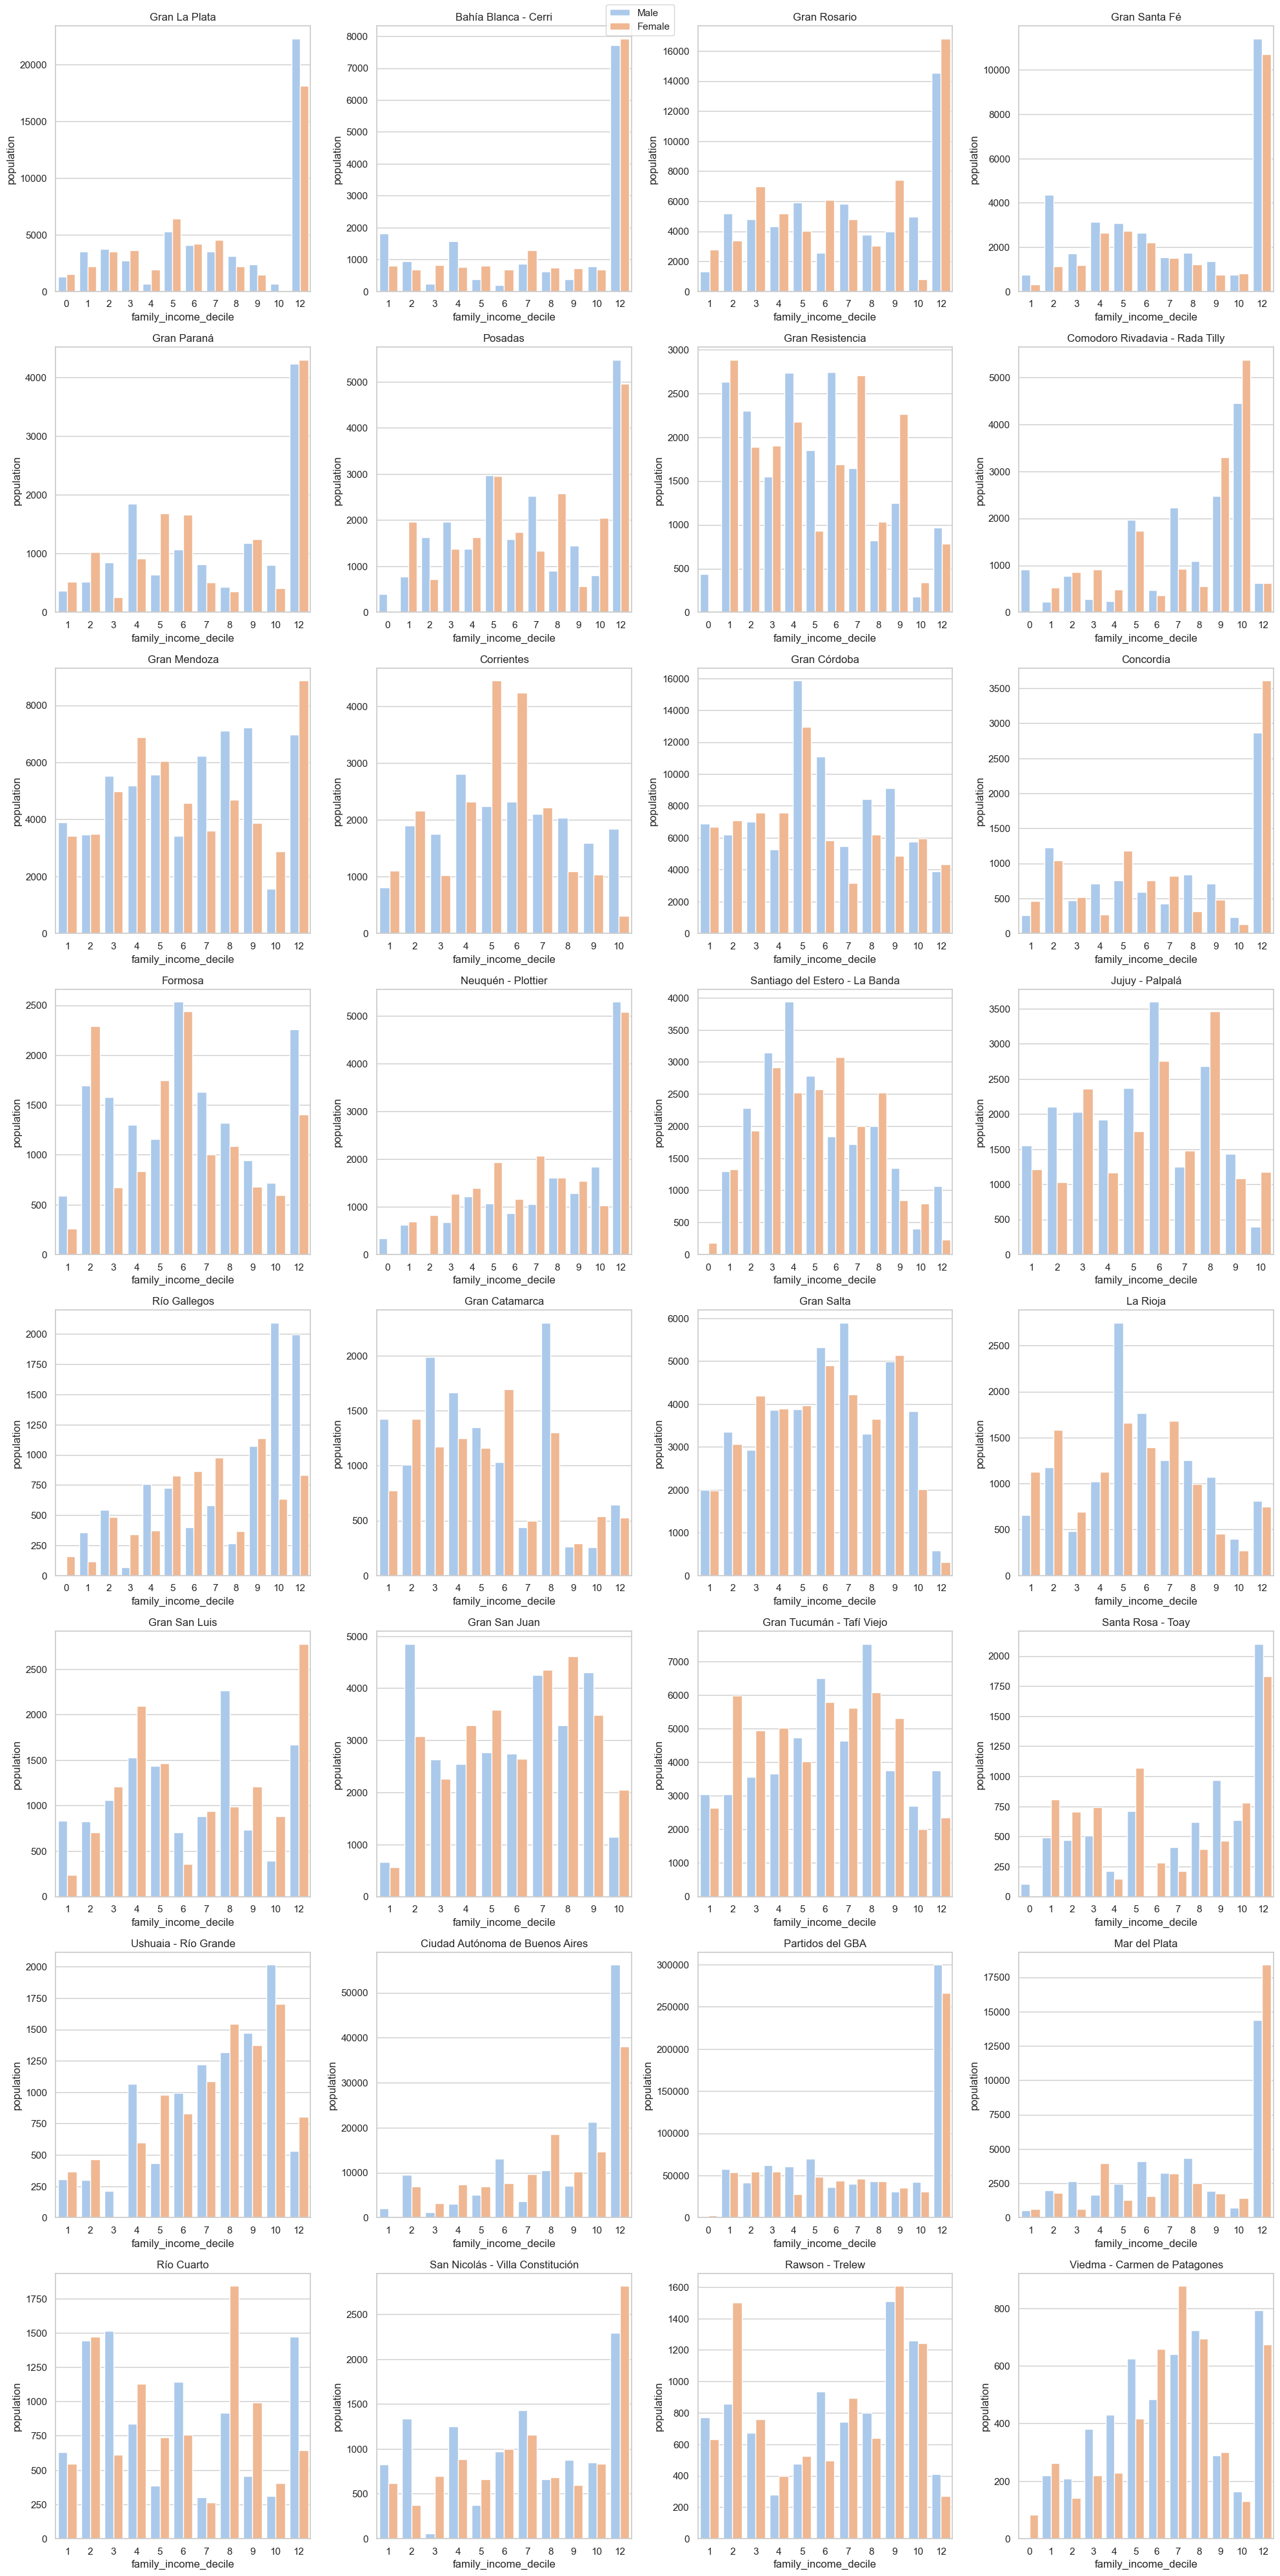

In [98]:
fig, axes = plt.subplots(8, 4, figsize=(20,40))
for axis, aggl in zip(axes.ravel(), agglomerations.values()):
    sns.barplot(overaged_by_aggl[overaged_by_aggl.agglomeration == aggl],
                x='family_income_decile',
                y='population',
                hue='gender',
                errorbar=None,
                ax=axis
                )
    axis.title.set_text(aggl)
    axis.legend_.remove()
    handles, labels = axis.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
fig.tight_layout()

As it can be seen in the plots before, the majority of the overaged population comes from a 12th decile: 12 is the code used by the EPH to identify those who did not answer questions regarding family or individual income.

TODOs: 
1. Resize and prettify the seaborn plot for all agglomerations.
2. Plotly plot with population distribution by gender with agglomeration filtering. This should be far better than point 1.

### 2. What is the relation between household income and education status?

### 3. Is education level and status uniform accross all agglomerations?

## Making a dataset

Since both DataFrames have too many features, lets make some feature engineergin to make a new dataset. The main objective here is to make a unique dataset where:
1. Each register is one individual.
2. Household characteristics are encoded into two or three features only.
3. Keeps one feature for individual income and one for household income.
4. Has only two features for income decile (one for individual and one for household).
5. Has all the relevant educational data.

Let's begin by encoding household features.

Household infrastructure characteristics are mostly contained through columns that begin with IV. All of them have categorical values encoded by whole numbers. For example:
| Feature | Values |
| ----------- | ----------- |
| IV5 | Does the roof have a ceiling/lining? 1 = Yes 2 = No|
| IV6 | It has water... 1. through pipes inside the house 2. outside the house but inside the land 3. outside the land|


In [ ]:
# filter IV columns
infra_col_filter = [col for col in eph_home if col.startswith('IV')]

In [ ]:
# Most of them are highly correlated.
# For example, almost no house with a roof ceiling has water through pipes inside the house
eph_home[infra_col_filter].query('IV5 == 1 and IV6 == 3')

,IV1,IV1_ESP,IV2,IV3,IV3_ESP,IV4,IV5,IV6,IV7,IV7_ESP,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3
2468,1,NaN,1,1,NaN,4,1,3,1,NaN,1,3,2,2,2,1,2
5337,2,NaN,2,1,NaN,4,1,3,1,NaN,1,1,2,2,1,2,2
8095,1,NaN,3,1,NaN,3,1,3,2,NaN,1,1,2,4,2,1,2
8862,1,NaN,3,2,NaN,4,1,3,2,NaN,1,1,2,1,2,2,2
11643,1,NaN,2,1,NaN,2,1,3,1,NaN,1,1,2,3,2,2,2


The IVn_ESP columns are almost full of NaNs because they are used to register different options of the category "Others" in the IVn columns. Since this offer little information, I am going to drop them.

On the other side, most of the columns offer little variability between categories.

In [ ]:
infra = eph_home[infra_col_filter].drop(['IV1_ESP', 'IV3_ESP', 'IV7_ESP'], axis=1)

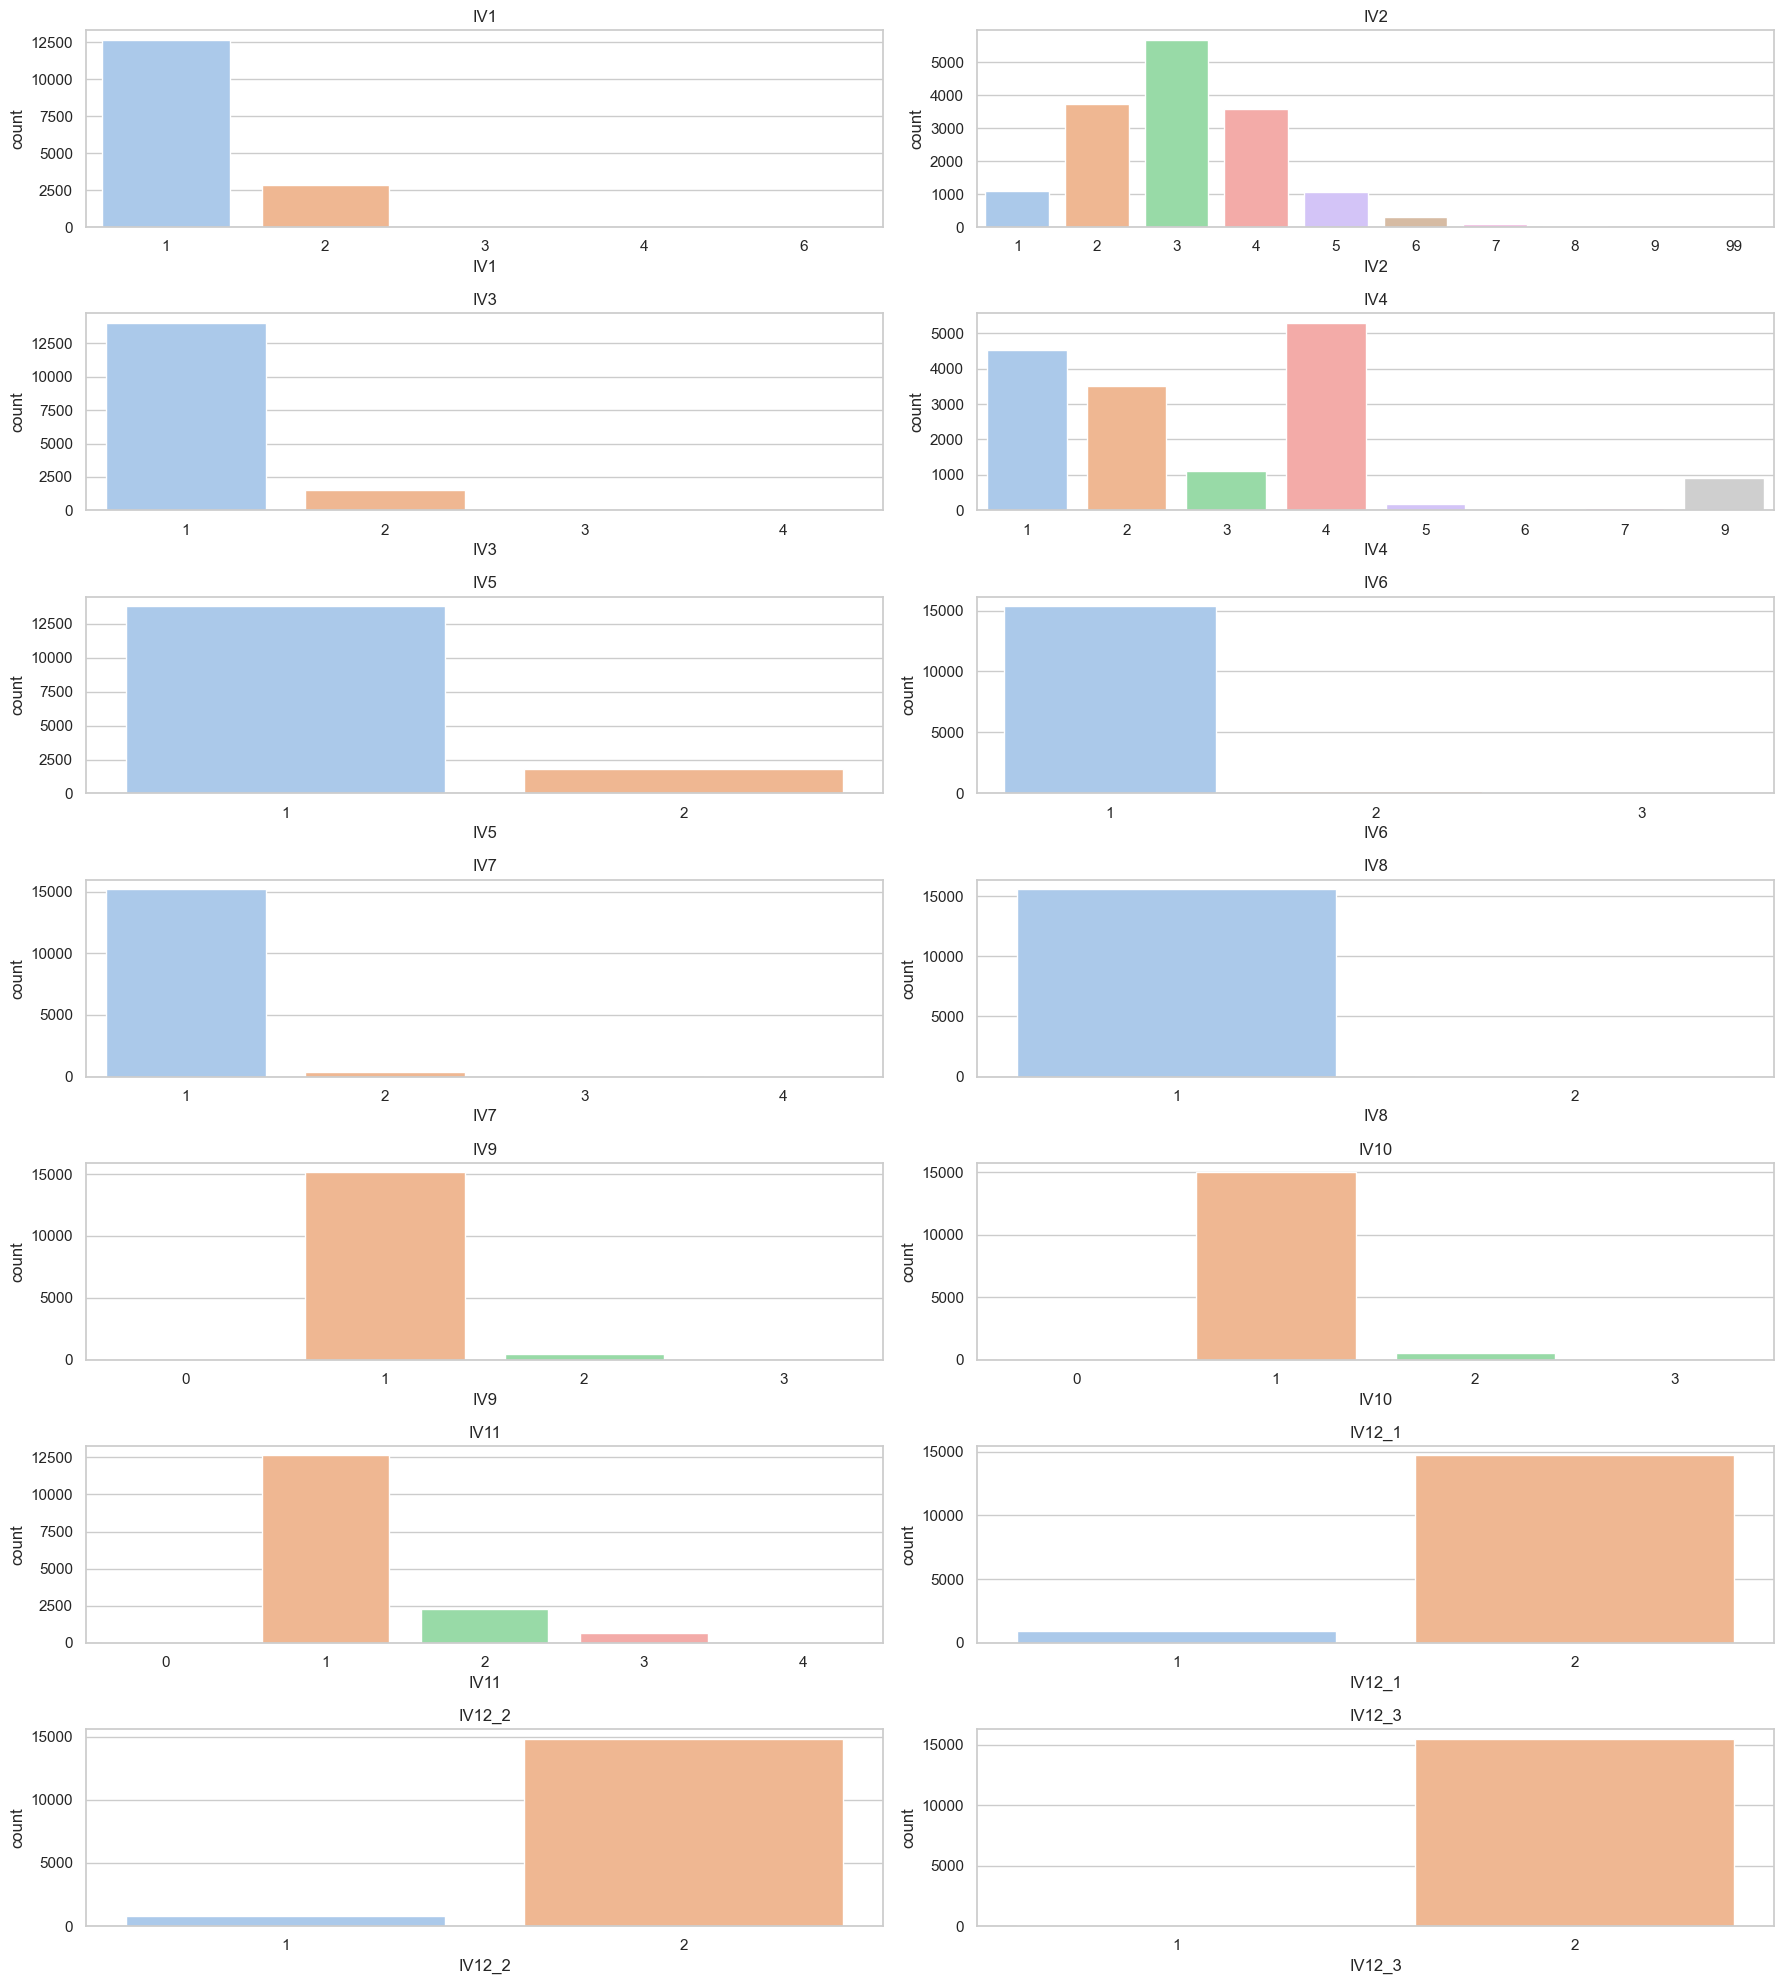

In [ ]:
fig, axes = plt.subplots(infra.columns.size // 2, infra.columns.size // 7, figsize=(18,20))
for axis, col in zip(axes.ravel(), infra.columns):
    sns.countplot(infra, x=col, ax=axis)
    axis.title.set_text(col)
fig.tight_layout()

Only columns IV2 (number of rooms in the house), IV4 (material of the outer covering of the roof) and IV9 (if the bathroom is inside or outside of the house) have classes with some balance. I will keep those for the analysis.

In [ ]:
cols_to_keep = ['CODUSU', 'NRO_HOGAR', 'REALIZADA', 'ANO4', 'TRIMESTRE', 'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA',
               'IV4', 'IV9']

Columns starting with II register characteristics of the house in terms of rooms.

In [ ]:
rooms_col_filter = [col for col in eph_home if col.startswith('II')]

In [ ]:
rooms = eph_home[rooms_col_filter].drop(['II7_ESP', 'II8_ESP'], axis=1) #IIn_ESP are used as "others" category
rooms.head()

,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9
0,1,1,2,0,1,2,2,2,0,2,0,1,2,1
1,3,2,2,0,1,2,1,2,0,2,0,1,1,1
2,3,1,2,0,1,1,1,2,0,2,0,1,1,1
3,1,1,2,0,1,2,2,2,0,2,0,2,1,1
4,1,1,2,0,1,1,1,2,0,2,0,1,2,1


Columns 1 to 3 are used to register how many rooms are exclusive to the household, how many of those rooms are used to sleep and if any of those rooms are used exclusively as work areas. II7 is used to keep information about the possession regime of the house (if it's owned or rented, etc.).

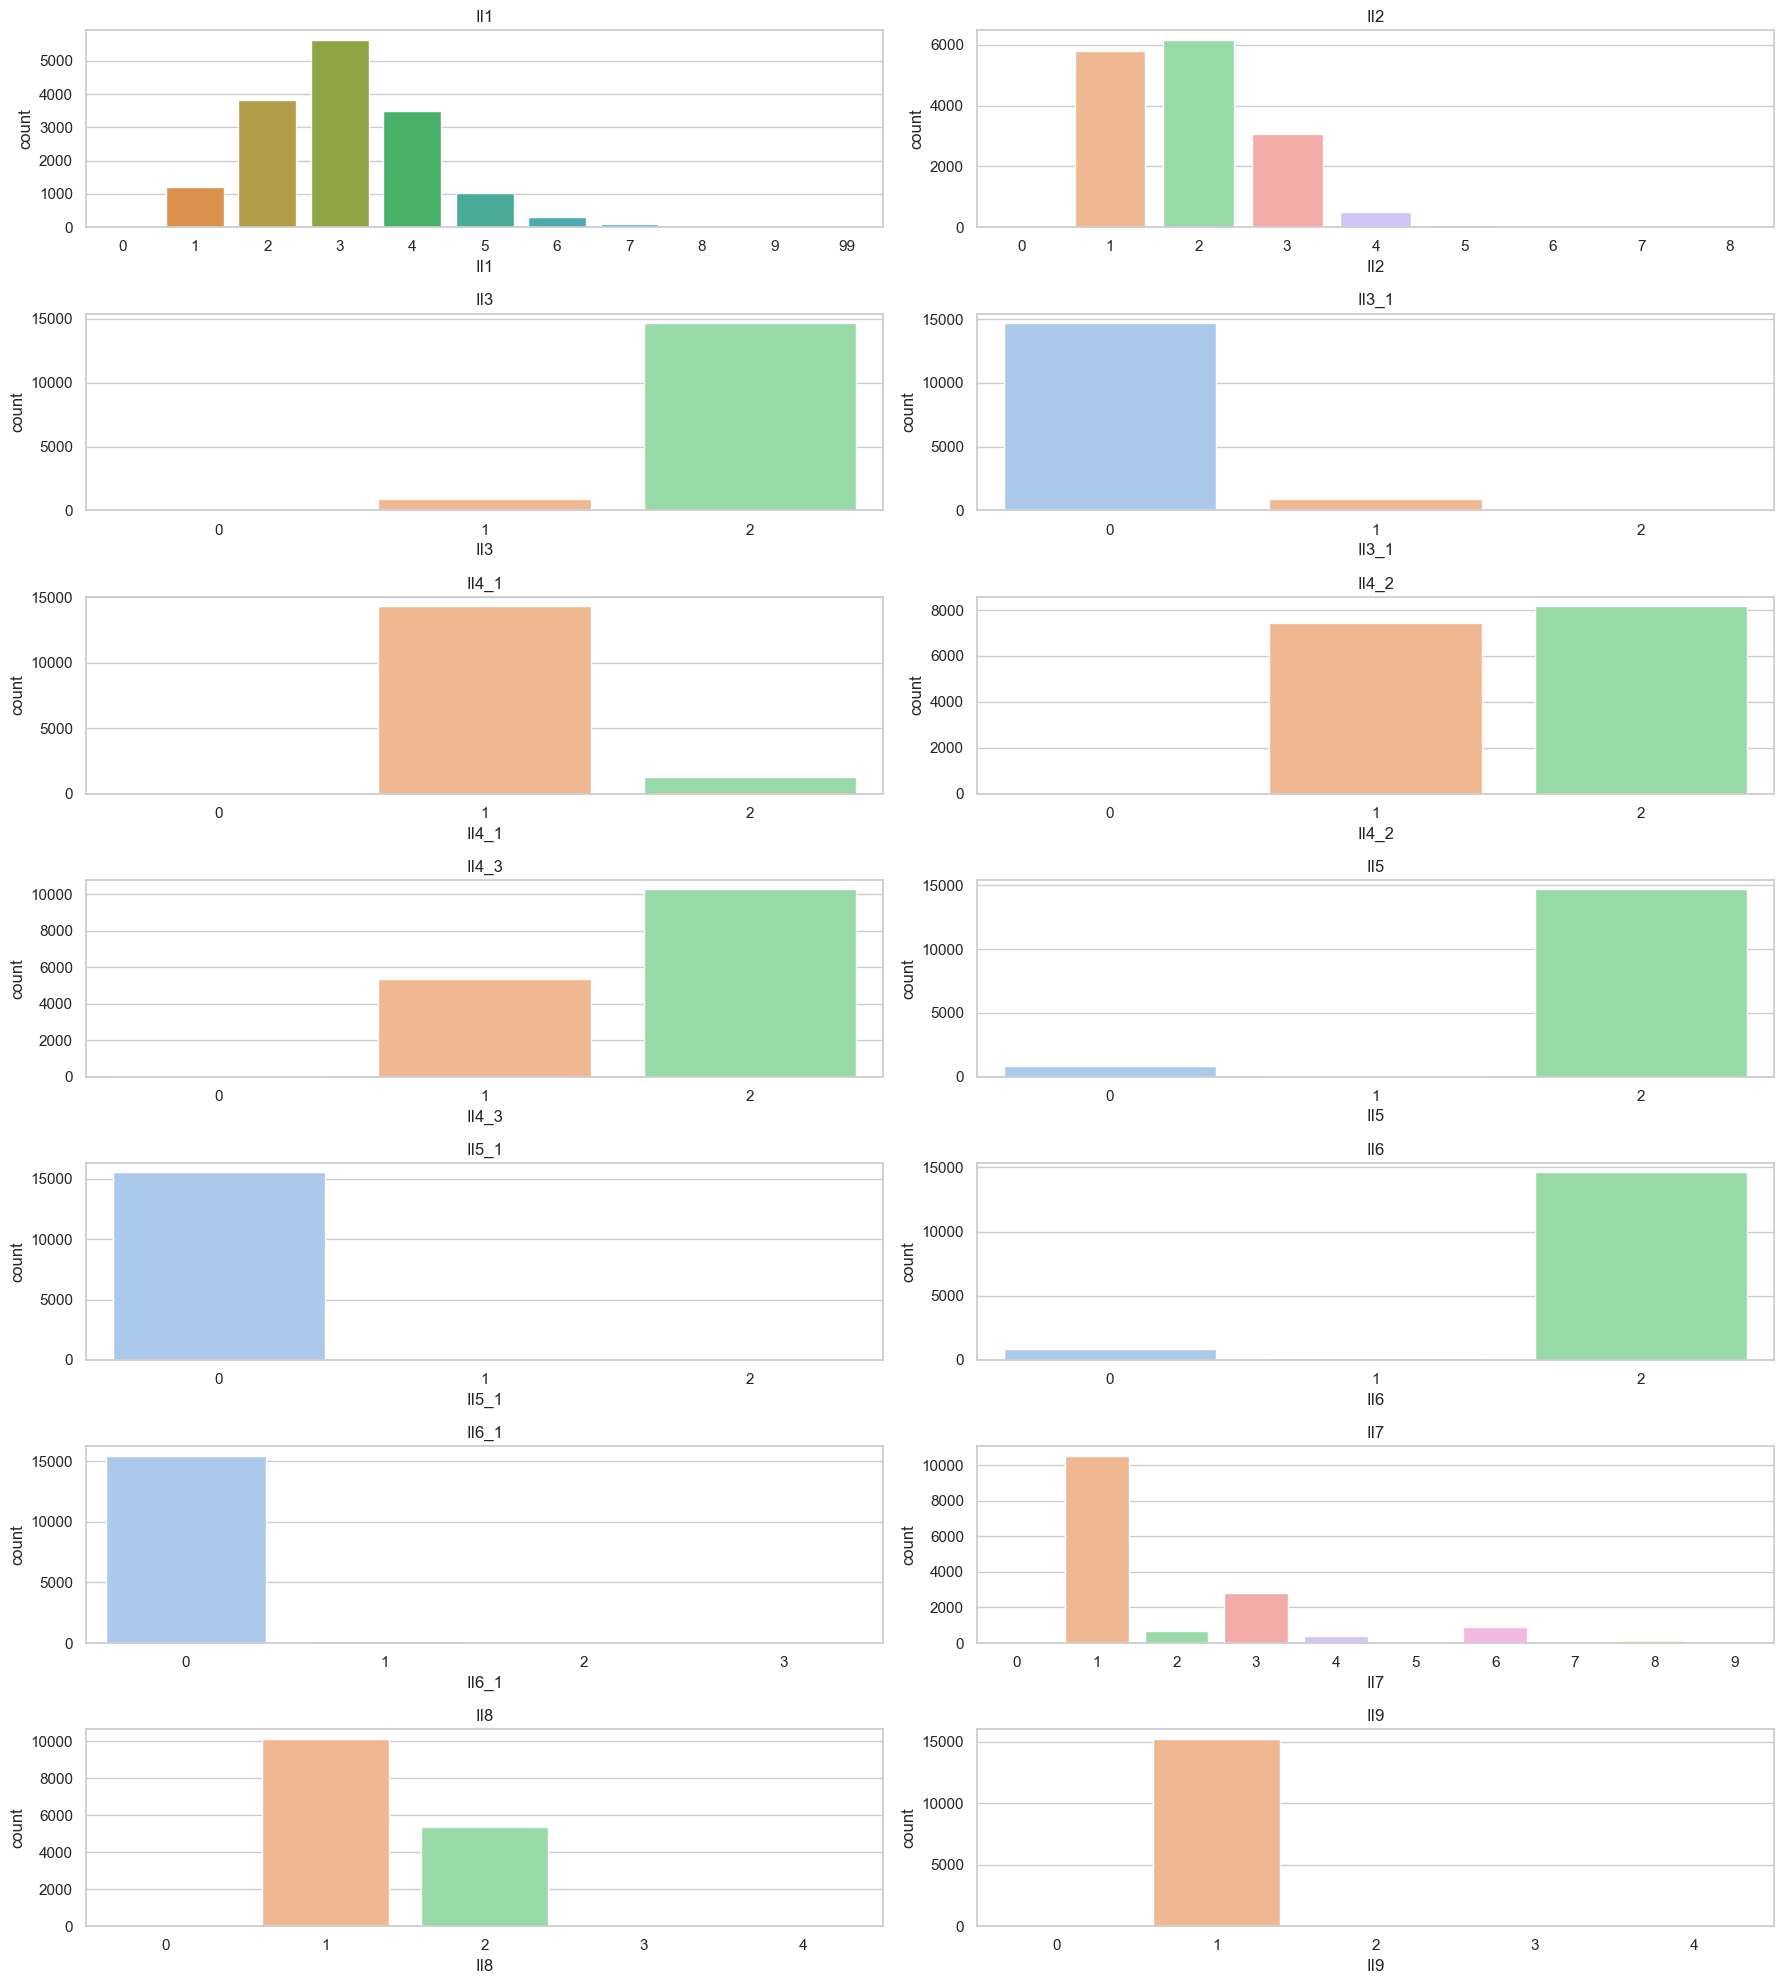

In [ ]:
fig, axes = plt.subplots(rooms.columns.size // 2, rooms.columns.size // 7, figsize=(18,20))
for axis, col in zip(axes.ravel(), rooms.columns):
    sns.countplot(rooms, x=col, ax=axis)
    axis.title.set_text(col)
fig.tight_layout()

Keep the first two while, and add II7.

In [ ]:
cols_to_keep.extend(['II1', 'II2', 'II7'])

In [ ]:
cols_to_keep

['CODUSU',
 'NRO_HOGAR',
 'REALIZADA',
 'ANO4',
 'TRIMESTRE',
 'REGION',
 'MAS_500',
 'AGLOMERADO',
 'PONDERA',
 'IV4',
 'IV9',
 'II1',
 'II2',
 'II7']

Questions starting with V refer to household economic strategies. Lets plot them.

In [ ]:
strat_col_filter = [col for col in eph_home if col.startswith('V')][0:22] # only the first 21

In [ ]:
strategies = eph_home[strat_col_filter]
strategies.head()

,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,...,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B
0,1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,1,2,2,2,2,2,2,2,2,2,...,2,2,1,2,2,1,2,2,2,2
2,2,1,2,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2
3,1,2,2,2,2,2,2,2,2,2,...,2,2,2,1,2,1,1,2,2,2
4,1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2


In [ ]:
strategies.columns.shape

(22,)

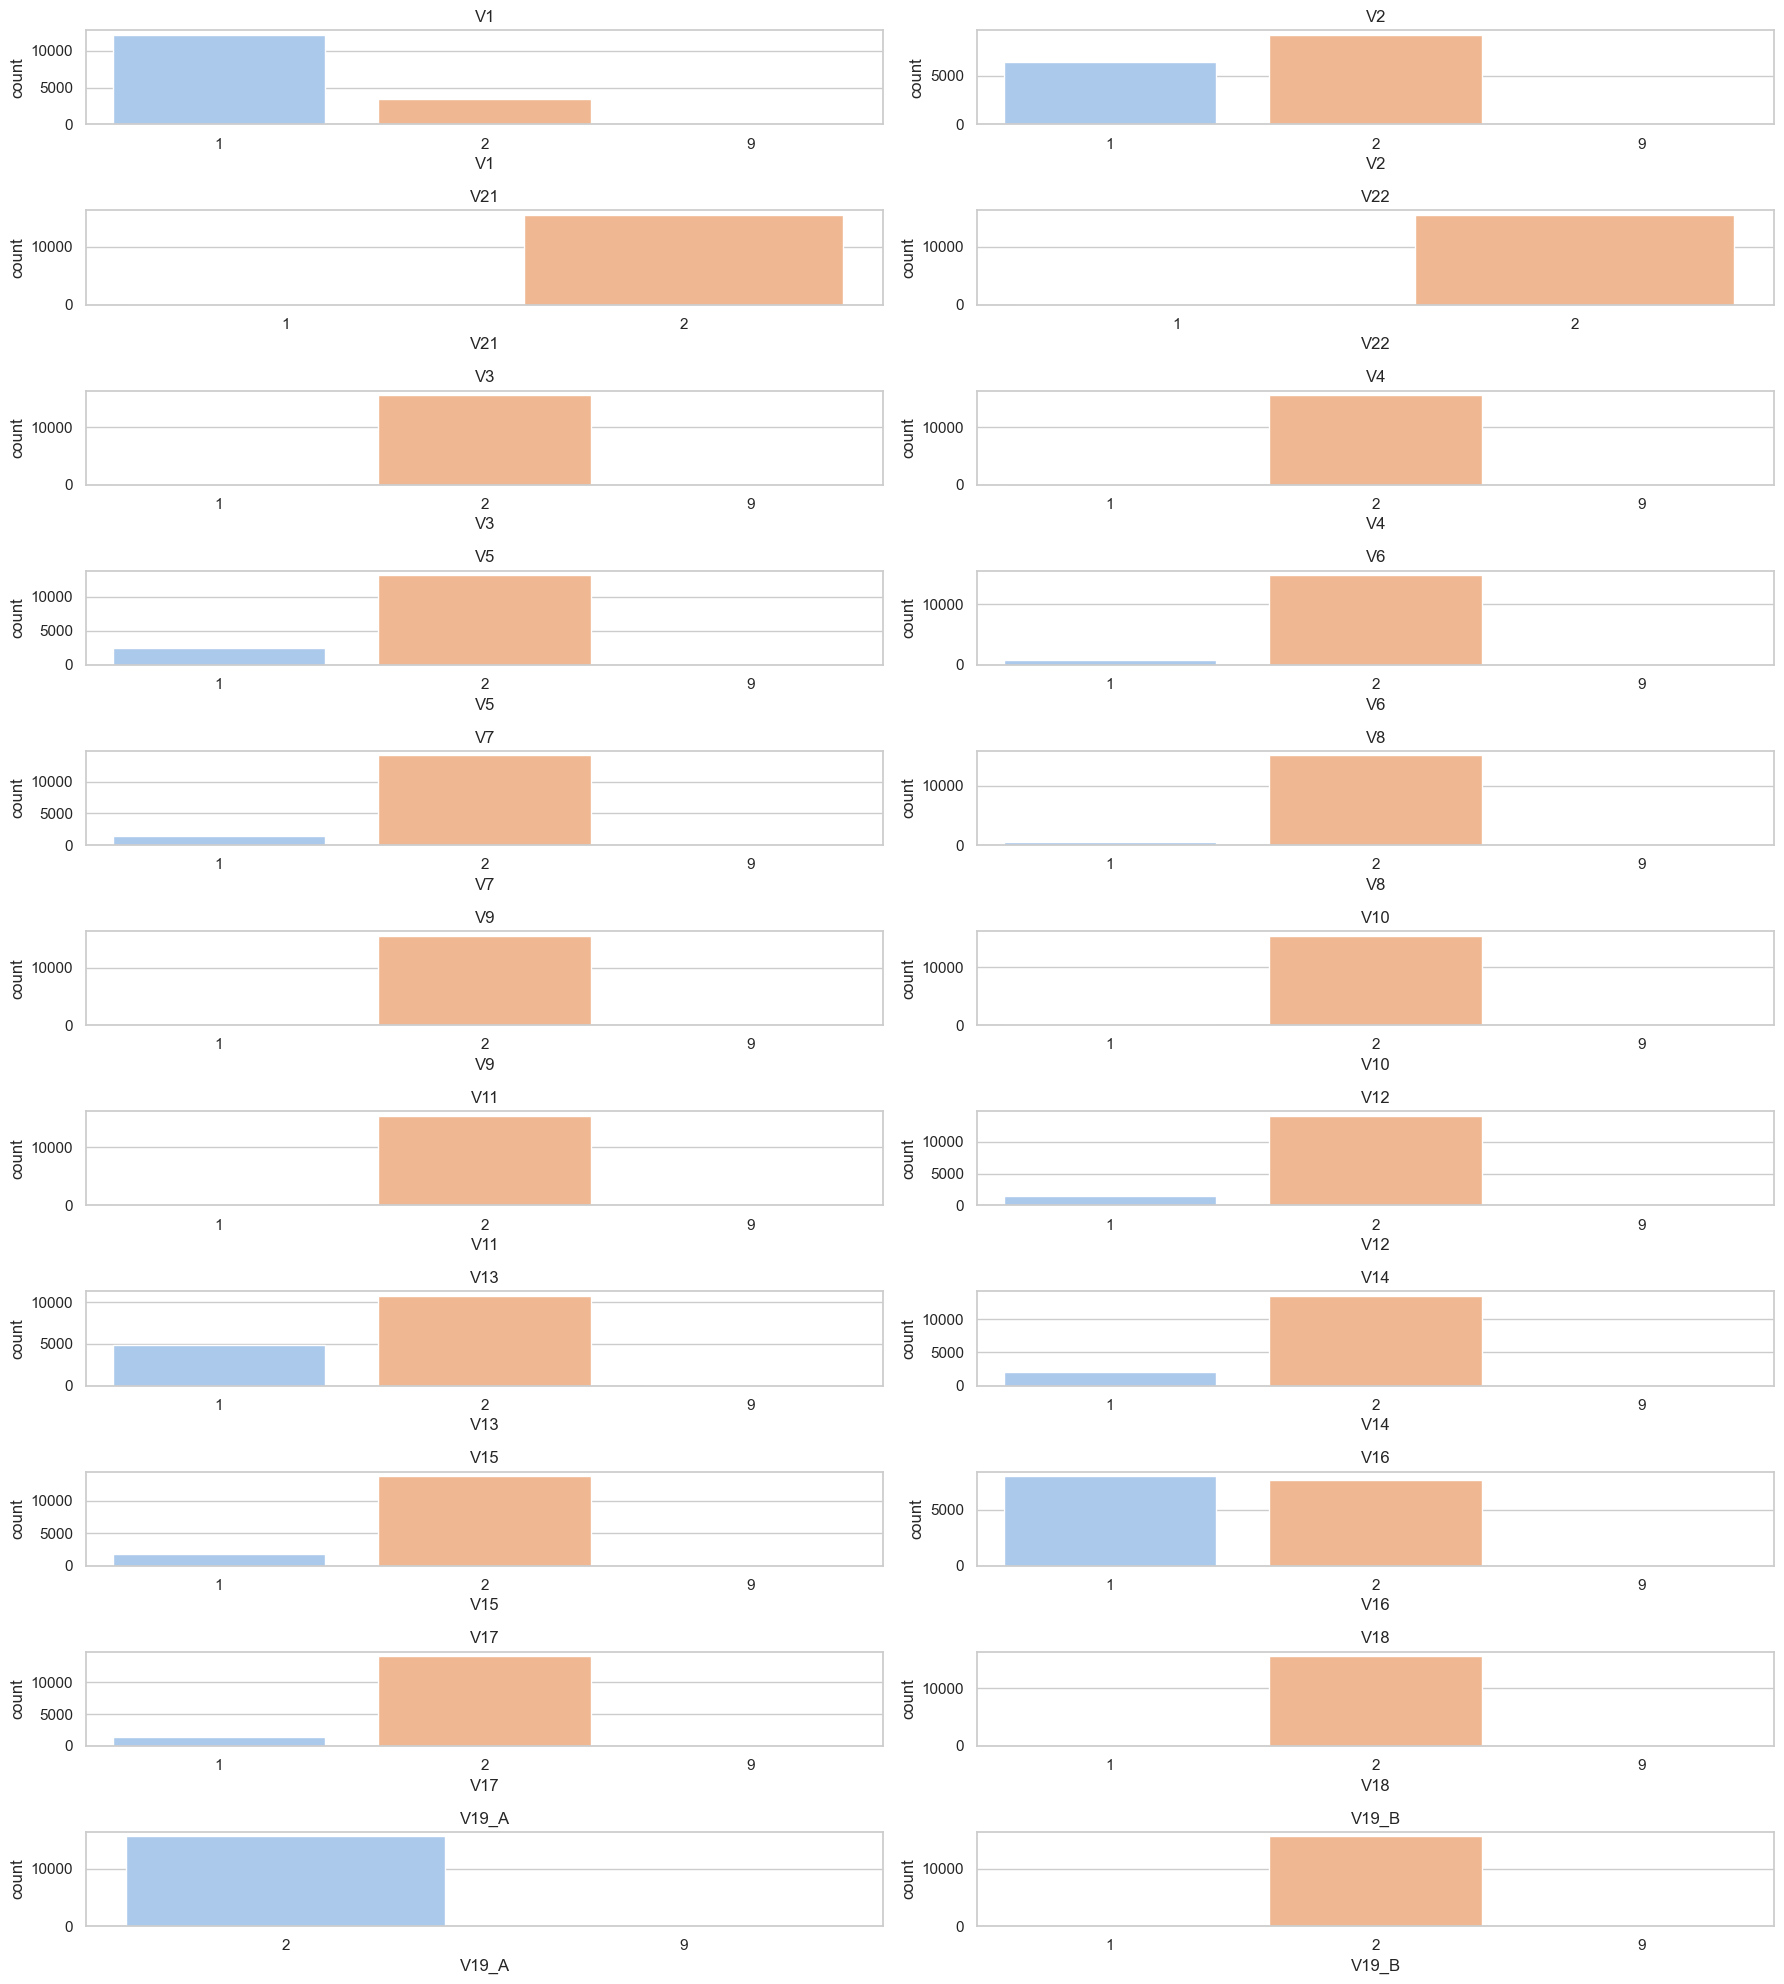

In [ ]:
fig, axes = plt.subplots(strategies.columns.size // 2, strategies.columns.size // 11, figsize=(18,20))
for axis, col in zip(axes.ravel(), strategies.columns):
    sns.countplot(strategies, x=col, ax=axis)
    axis.title.set_text(col)
fig.tight_layout()

Won't keep any oh these. Let's continue by adding the summary cols and two referring to the household income: total income and decile.

In [ ]:
cols_to_keep.extend(['IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'ITF', 'DECIFR'])
cols_to_keep

['CODUSU',
 'NRO_HOGAR',
 'REALIZADA',
 'ANO4',
 'TRIMESTRE',
 'REGION',
 'MAS_500',
 'AGLOMERADO',
 'PONDERA',
 'IV4',
 'IV9',
 'II1',
 'II2',
 'II7',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'ITF',
 'DECIFR']

In [ ]:
cols_to_keep.extend(['V11'])

In [ ]:
home = eph_home[cols_to_keep]

Now, let's continue with the individual database.

In [ ]:
cols_to_keep_i = ['CODUSU', 'NRO_HOGAR', 'H15', 'ANO4', 'TRIMESTRE', 'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA']
ch_cols = [col for col in eph_people.columns if col.startswith('CH')][:14]
cols_to_keep_i.extend(ch_cols)

In [ ]:
cols_to_keep_i.extend(['NIVEL_ED', 'CAT_OCUP', 'CAT_INAC'])

In [ ]:
cols_to_keep_i.extend(['P47T', 'DECINDR', 'PONDII', 'V11_M'])

In [ ]:
individual = eph_people[cols_to_keep_i]

In [ ]:
data = individual.merge(home, on=['CODUSU', 'NRO_HOGAR', 'ANO4', 'TRIMESTRE', 'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA'], how='inner')

In [ ]:
data.shape

(47085, 42)

In [ ]:
eph_people3 = pyeph.get(data="eph", year=2021, period=3, tipo_base='individual')

 92% [....................................................................      ] 2220032 / 2390825

100% [..........................................................................] 2390825 / 2390825
Obtenido con exito: base_individual_2021T3.zip 


Column CH10 is the question of wether the person attends school or doesn't. I will add that column to the data dataframe and then filter for people who haven't finished school, went to school but don't go anymore.

In [ ]:
third = eph_people3[['CODUSU', 'NRO_HOGAR', 'CH10']].rename({'CH10': 'CH10_3'}, axis=1)
third.head()

,CODUSU,NRO_HOGAR,CH10_3
0,TQRMNOSRVHJOLOCDEGPDJ00658294,1,2
1,TQRMNOQXVHKMLNCDEGPDJ00661925,1,2
2,TQRMNOQXVHKMLNCDEGPDJ00661925,1,1
3,TQRMNOQXVHKMLNCDEGPDJ00661925,1,2
4,TQRMNOQXVHKMLNCDEGPDJ00661925,1,1


In [ ]:
data = data.merge(third, on=['CODUSU', 'NRO_HOGAR'])
data.head()

,CODUSU,NRO_HOGAR,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,...,II1,II2,II7,IX_TOT,IX_MEN10,IX_MAYEQ10,ITF,DECIFR,V11,CH10_3
0,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,1,...,4,3,2,5,1,4,26000,2,2,2
1,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,1,...,4,3,2,5,1,4,26000,2,2,1
2,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,1,...,4,3,2,5,1,4,26000,2,2,1
3,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,1,...,4,3,2,5,1,4,26000,2,2,1
4,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,1,...,4,3,2,5,1,4,26000,2,2,1


In [ ]:
# all of this dropped
data[(data.NIVEL_ED < 6) & (data.CH13 == 2) & (data.CH10 == 1) & (data.CH10_3 == 2)]

,CODUSU,NRO_HOGAR,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,...,II1,II2,II7,IX_TOT,IX_MEN10,IX_MAYEQ10,ITF,DECIFR,V11,CH10_3
5,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,3,...,4,3,2,5,1,4,26000,2,2,2
10,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,3,...,4,3,2,5,1,4,26000,2,2,2
15,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,3,...,4,3,2,5,1,4,26000,2,2,2
30,TQRMNOQRPHLMPNCDEIJAH00708318,1,1,2021,2,1,S,33,4724,2,...,4,3,4,5,0,5,50000,4,2,2
35,TQRMNOQRPHLMPNCDEIJAH00708318,1,1,2021,2,1,S,33,4724,3,...,4,3,4,5,0,5,50000,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79121,TQRMNOPUXHLOKTCDEOJAH00708360,1,1,2021,2,44,N,93,46,3,...,3,3,1,4,0,4,129000,9,2,2
79128,TQRMNOQUQHLOKTCDEOJAH00708361,1,0,2021,2,44,N,93,49,3,...,3,2,1,3,1,2,120000,9,2,2
79129,TQRMNOQUQHLOKTCDEOJAH00708361,1,0,2021,2,44,N,93,49,3,...,3,2,1,3,1,2,120000,9,2,2
79137,TQRMNOQUPHJKLLCDEOJAH00659449,1,1,2021,2,44,N,93,111,3,...,5,2,1,3,0,3,95000,8,2,2


In [ ]:
drop_cond = (data.NIVEL_ED < 6) & (data.CH13 == 2) & (data.CH10 == 1) & (data.CH10_3 == 2)
data['dropped'] = np.where(drop_cond, 1, 0)

In [ ]:
data.head()

,CODUSU,NRO_HOGAR,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,...,II2,II7,IX_TOT,IX_MEN10,IX_MAYEQ10,ITF,DECIFR,V11,CH10_3,dropped
0,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,1,...,3,2,5,1,4,26000,2,2,2,0
1,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,1,...,3,2,5,1,4,26000,2,2,1,0
2,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,1,...,3,2,5,1,4,26000,2,2,1,0
3,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,1,...,3,2,5,1,4,26000,2,2,1,0
4,TQRMNOPQRHLOKOCDEHJGH00708317,1,1,2021,2,40,S,23,250,1,...,3,2,5,1,4,26000,2,2,1,0


In [ ]:
data.drop(['CH10', 'CH10_3'], axis=1, inplace=True)

In [ ]:
data.to_csv('data.csv', index=False)

In [ ]:
data.shape

(79144, 42)

In [ ]:
data.dropped.value_counts()

0    67299
1    11845
Name: dropped, dtype: int64